In [1]:
from leven import levenshtein
import numpy as np
import mxnet as mx
import nltk
import math
import string
import random
random.seed(123)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform as skimage_tf
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection, box_nms
from pycontractions import Contractions
import gluonnlp
import difflib

from utils.iam_dataset import IAMDataset, resize_image, crop_image
from utils.CTCDecoder.BeamSearch import ctcBeamSearch
from utils.CTCDecoder.LexiconSearch import ctcLexiconSearchWithNLTK
from utils.lexicon_search import LexiconSearch
from utils.expand_bounding_box import expand_bounding_box
from utils.sclite_helper import Sclite_helper

from paragraph_segmentation_dcnn import make_cnn as ParagraphSegmentationNet
from line_segmentation import SSD as LineSegmentationNet
from word_segmentation import SSD as WordSegmentationNet
from handwriting_line_recognition import Network as HandwritingRecognitionNet
from handwriting_line_recognition import decode as decoder_handwriting

In [2]:
ctx = mx.gpu(0)

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results. Randomly select 4 images for analysis.

In [3]:
test_ds = IAMDataset("form_original", train=False)

In [4]:
figs_to_plot = 4
images = []

for i in range(0, figs_to_plot):
    #n = int(random.random()*len(test_ds))
    n = [6, 17, 21, 27][i]
    image, _ = test_ds[n]
    images.append(image)

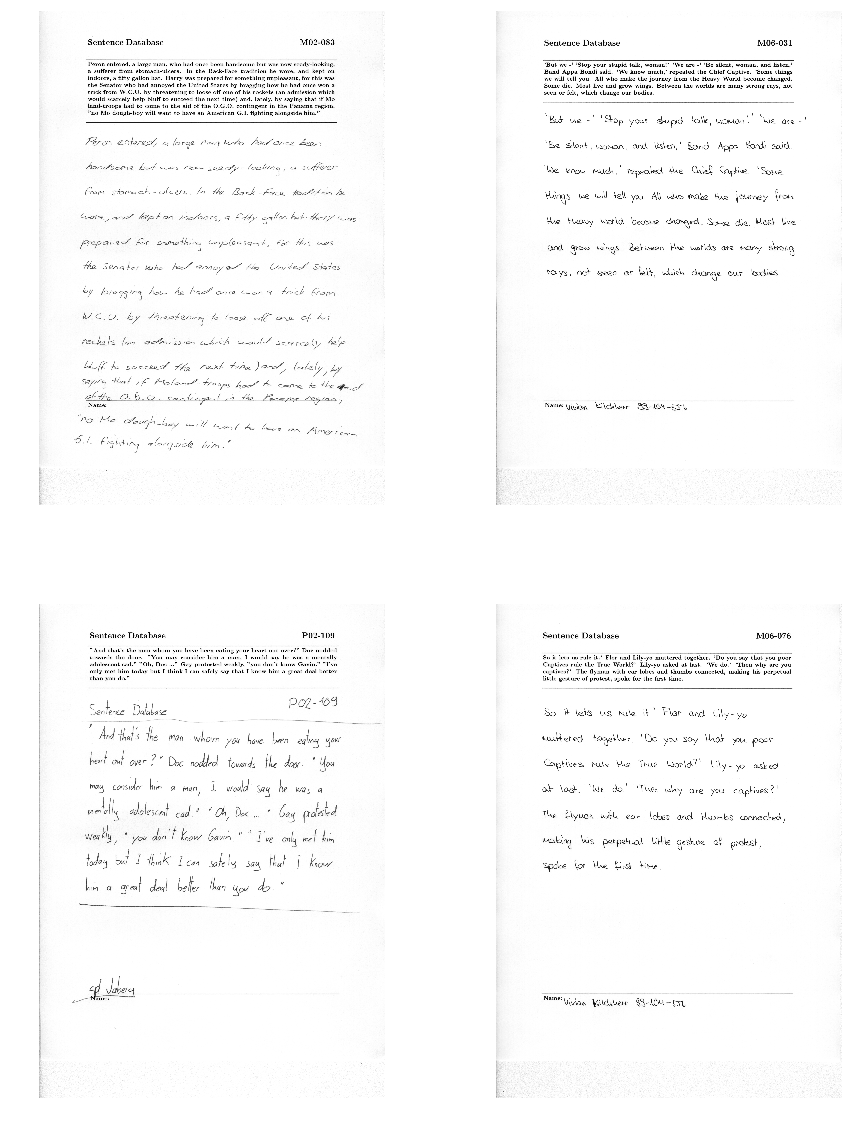

In [5]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

## Paragraph segmentation
Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [6]:
paragraph_segmentation_net = ParagraphSegmentationNet()
paragraph_segmentation_net.load_parameters("models/paragraph_segmentation2.params")

In [7]:
def paragraph_segmentation_transform(image, image_size):
    resized_image, _ = resize_image(image, image_size)
    
    resized_image = mx.nd.array(resized_image).expand_dims(axis=2)
    resized_image = mx.image.resize_short(resized_image, int(800/3))
    resized_image = resized_image.transpose([2, 0, 1])/255.

    resized_image = resized_image.as_in_context(ctx)
    resized_image = resized_image.expand_dims(axis=0)
    return resized_image

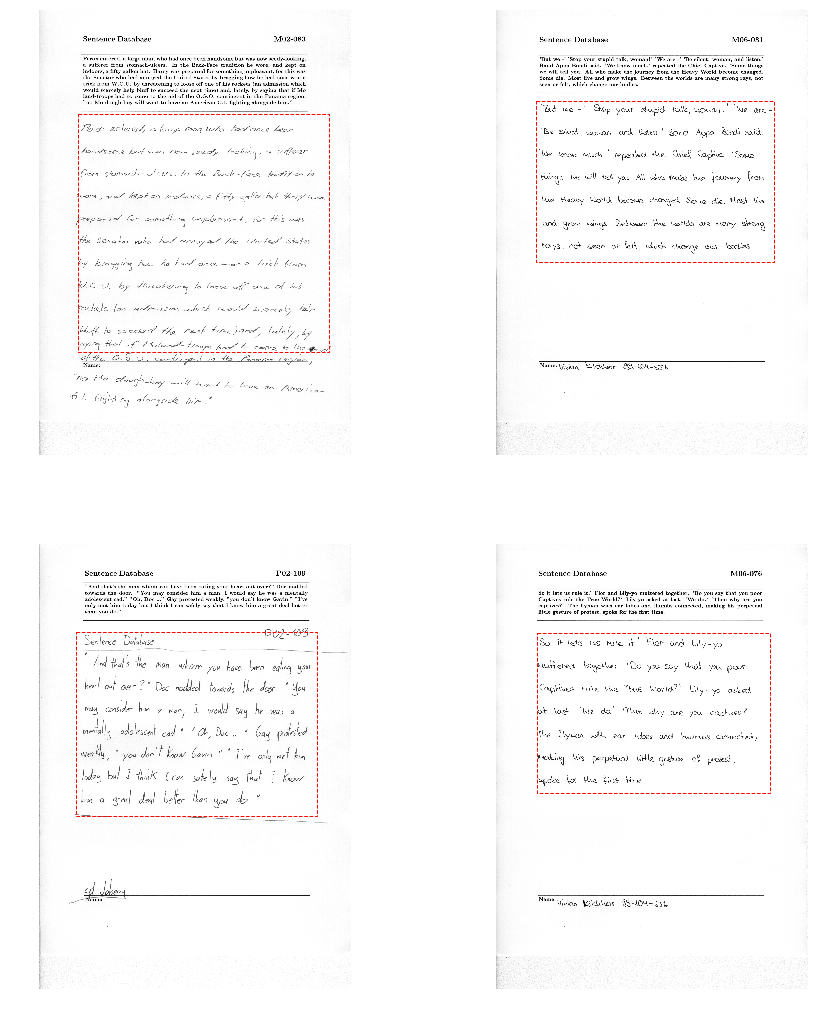

In [8]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image)
    
    bb_predicted = bb_predicted[0].asnumpy()

    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

#### Image processing
Crop the handwriting component out of the original IAM form.

In [9]:
def crop_handwriting_page(image, bb, image_size):
    '''
    Given an image and bounding box (bb) crop the input image based on the bounding box.
    The final output image was scaled based on the image size.
    
    Parameters
    ----------
    image: np.array
        Input form image
    
    bb: (x, y, w, h)
        The bounding box in percentages to crop
        
    image_size: (h, w)
        Image size to scale the output image to.
        
    Returns
    -------
    output_image: np.array
        cropped image of size image_size.
    '''
    expanded_bb = expand_bounding_box(bb)
    image = crop_image(image, expanded_bb)

    image, _ = resize_image(image, desired_size=image_size)
    return image

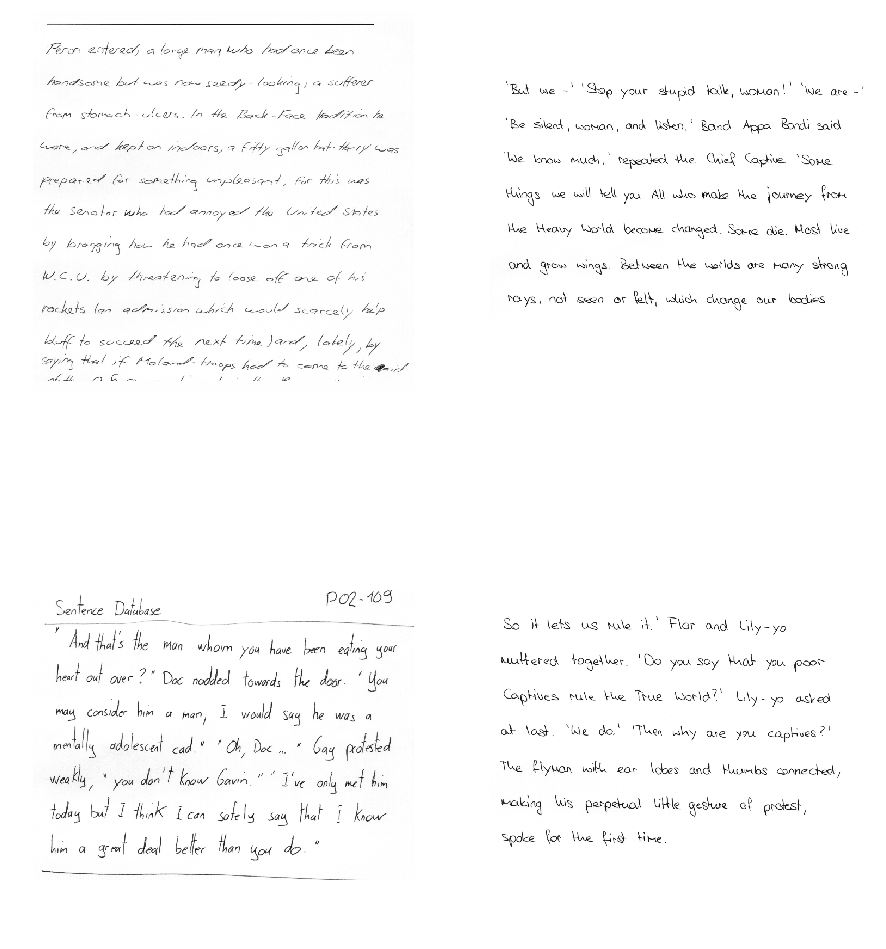

In [10]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## Line/word segmentation
Given a form with only handwritten text, predict a bounding box for each word. The model was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/word_segmentation.py

In [11]:
def predict_bounding_boxes(net, image, min_c, overlap_thres, topk):
    '''
    Given the outputs of the dataset (image and bounding box) and the network, 
    the predicted bounding boxes are provided.
    
    Parameters
    ----------
    net: SSD
    The trained SSD network.
    
    image: np.array
    A grayscale image of the handwriting passages.
        
    Returns
    -------
    predicted_bb: [(x, y, w, h)]
    The predicted bounding boxes.
    '''
    image = mx.nd.array(image).expand_dims(axis=2)
    image = mx.image.resize_short(image, 350)
    image = image.transpose([2, 0, 1])/255.

    image = image.as_in_context(ctx)
    image = image.expand_dims(0)
    
    bb = np.zeros(shape=(13, 5))
    bb = mx.nd.array(bb)
    bb = bb.as_in_context(ctx)
    bb = bb.expand_dims(axis=0)

    default_anchors, class_predictions, box_predictions = net(image)
           
    box_target, box_mask, cls_target = net.training_targets(default_anchors, 
                                                            class_predictions, bb)

    cls_probs = mx.nd.SoftmaxActivation(mx.nd.transpose(class_predictions, (0, 2, 1)), mode='channel')

    predicted_bb = MultiBoxDetection(*[cls_probs, box_predictions, default_anchors], force_suppress=True, clip=False)
    predicted_bb = box_nms(predicted_bb, overlap_thresh=overlap_thres, valid_thresh=min_c, topk=topk)
    predicted_bb = predicted_bb.asnumpy()
    predicted_bb = predicted_bb[0, predicted_bb[0, :, 0] != -1]
    predicted_bb = predicted_bb[:, 2:]
    predicted_bb[:, 2] = predicted_bb[:, 2] - predicted_bb[:, 0]
    predicted_bb[:, 3] = predicted_bb[:, 3] - predicted_bb[:, 1]

    return predicted_bb

In [12]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation.params")

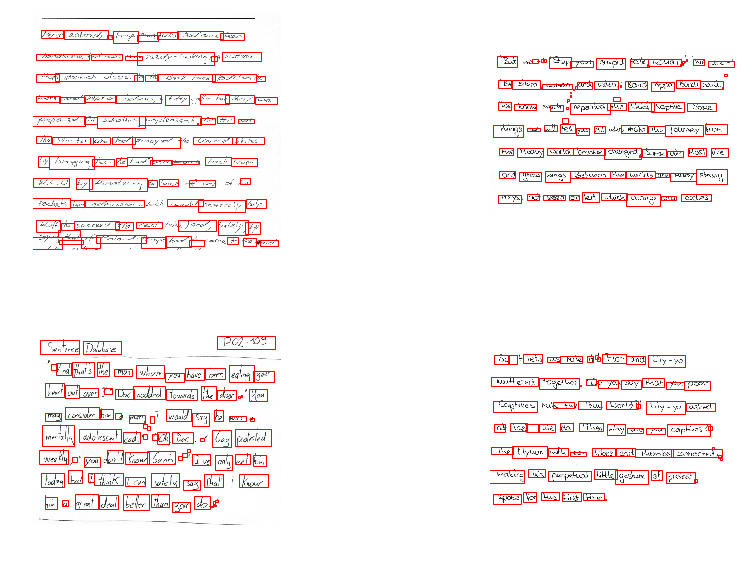

In [13]:
min_c = 0.01
overlap_thres = 0.001
topk = 400

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk)
    
    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')

    for j in range(predicted_bb.shape[0]):                
        (x, y, w, h) = expand_bounding_box(predicted_bb[j], expand_bb_scale_x=0.2,
                                           expand_bb_scale_y=0.01)
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

#### Word to line image processing
Algorithm to sort then group all words within a line together.

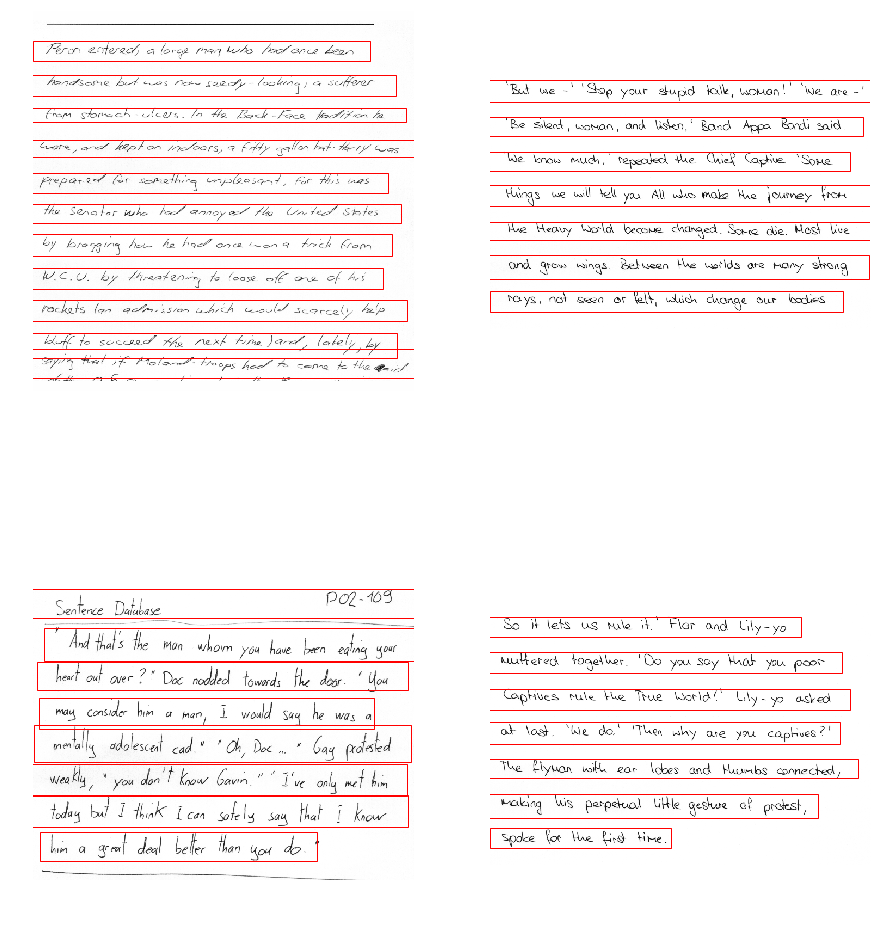

In [14]:
from scipy.cluster.hierarchy import fcluster

def clip_value(value, max_value):
    '''
    Helper function to make sure that "value" will not be greater than max_value
    or lower than 0.
    '''
    output = value
    if output < 0:
        output = 0
    if output > max_value:
        output = max_value
    return int(output)

def get_max_coord(bbs, x_or_y):
    '''
    Helper function to find the largest coordinate given a list of
    bounding boxes in the x or y direction.
    '''
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    max_value = 0.0
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0] + bb[2]
        else:
            value = bb[1] + bb[3]
        if value > max_value:
            max_value = value
    return max_value

def get_min_coord(bbs, x_or_y):
    '''
    Helper function to find the largest coordinate given a list of
    bounding boxes in the x or y direction.
    '''
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    min_value = 100
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0]
        else:
            value = bb[1]
        if value < min_value:
            min_value = value
    return min_value

def get_bounding_box_of_bb_list(bbs_in_a_line, min_size=0.0005):
    '''
    Given a list of bounding boxes, find the maximum x, y and
    minimum x, y coordinates. This is the bounding box that
    emcompasses all the words. Return this bounding box in the form
    (x', y', w', h').
    '''
    # Remove bbs that are very small
    bbs = []
    for bb in bbs_in_a_line:
        if bb[2] * bb[3] > min_size:
            bbs.append(bb)
    
    max_x = get_max_coord(bbs, x_or_y="x")
    min_x = get_min_coord(bbs, x_or_y="x")

    max_y = get_max_coord(bbs, x_or_y="y")
    min_y = get_min_coord(bbs, x_or_y="y")
            
    line_bb = (min_x, min_y, max_x - min_x, max_y - min_y)
    line_bb = expand_bounding_box(line_bb, expand_bb_scale_x=0.1,
                                          expand_bb_scale_y=0.05)
    return line_bb

def filter_line_bbs(bbs, min_size=0.005):
    '''
    Remove line bounding boxes that are too small 
    '''
    output_bbs = []
    for bb in bbs:
        if bb[2] * bb[3] > min_size:
            output_bbs.append(bb)
    return output_bbs

def get_line_overlap_percentage(y1, h1, y2, h2):
    '''
    Calculates how much (percentage) y2->y2+h2 overlaps with y1->y1+h1.
    Algorithm assumes that y2 is larger than y1
    '''
    # Are the lines overlapping
    
    if y2 > y1 and (y1 + h1) > y2:
        # Is y2 enclosed in y1
        if (y1 + h1) > (y2 + h2):
            return 1.0
        else:
            return ((y1 + h1) - (y2))/h1
    else:
        return 0.0
        
def sort_bbs_line_by_line(bbs, y_overlap=0.2):
    '''
    Algorithm to group word crops into lines.
    Iterates over every word bb, if the overlap in the y direction
    between 2 boxes is greater than y_overlap, then group the words together.
    '''
    line_bbs = []
    bbs_in_a_line = []
    y_indexes = np.argsort(bbs[:, 1])
    
    # Iterate through the sorted bounding box.
    previous_y_coords = None
    for y_index in y_indexes:
        y_coords = (bbs[y_index, 1], bbs[y_index, 3]) # y and height
        
        # new line if the overlap is more than y_overlap
        if previous_y_coords is not None:
            line_overlap_percentage = get_line_overlap_percentage(
                previous_y_coords[0], previous_y_coords[1],
                y_coords[0], y_coords[1])
            if line_overlap_percentage < y_overlap: 
                line_bb = get_bounding_box_of_bb_list(bbs_in_a_line)
                line_bbs.append(line_bb)
                bbs_in_a_line = []
        bbs_in_a_line.append(bbs[y_index, :])
        previous_y_coords = y_coords
    
    # process the last line
    line_bb = get_bounding_box_of_bb_list(bbs_in_a_line)
    line_bbs.append(line_bb)
    line_bbs = filter_line_bbs(line_bbs)
    return line_bbs

def crop_line_images(image, line_bbs):
    '''
    Given the input form image, crop the image given a list of bounding boxes.
    '''
    line_images = []
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        x1 = clip_value(x, max_value=image_w)
        x2 = clip_value(x + w, max_value=image_w)
        y1 = clip_value(y, max_value=image_h)
        y2 = clip_value(y + h, max_value=image_h)
        
        line_image = image[y1:y2, x1:x2]    
        if line_image.shape[0] > 0 and line_image.shape[1] > 0:
            line_images.append(line_image)
    line_images_array.append(line_images)
    return line_images

line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

# Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [15]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=128,
                                                             rnn_layers=2, ctx=ctx)
handwriting_line_recognition_net.load_params("models/handwriting_line_recognition4.params")

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:421: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


In [16]:
line_image_size = (30, 400)
def handwriting_recognition_transform(image):
    '''
    Resize and normalise the image to be fed into the network.
    '''
    image, _ = resize_image(image, line_image_size)
    image = mx.nd.array(image)/255.
    image = (image - 0.942532484060557) / 0.15926149044640417
    image = image.as_in_context(ctx)
    image = image.expand_dims(0).expand_dims(0)
    return image

In [17]:
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image)
        line_character_prob = handwriting_line_recognition_net(line_image)
        form_character_prob.append(line_character_prob)

    character_probs.append(form_character_prob)

### Language model

In [18]:
ls = LexiconSearch()

In [19]:
contractions = Contractions('models/GoogleNews-vectors-negative300.bin.gz')
contractions.load_models()

In [20]:
lm_model, vocab = gluonnlp.model.get_model('awd_lstm_lm_1150', pretrained=True, ctx=ctx)

In [21]:
alphabet_encoding = r' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

def get_perplexcity(line_string, length_normalisation_factor=0.7):
    '''
    Algorithm to calculate the perplexicity of the string.
    1) Tokenise the string into words
    2) One-hot encode the tokenised string
    3) Fed the vector a language model to obtain the output probability
    4) Calculate the perplexcity
    '''
    word_tokenize = nltk.word_tokenize(line_string)
    bos_ids = [vocab[ele] for ele in word_tokenize] # One-hot encode the word tokens
    if len(bos_ids) == 1 or len(bos_ids) == 0:
        # if none of the words exist, return a large perplexcity.
        return 100000

    hidden = lm_model.begin_state(batch_size=1, func=mx.nd.zeros, ctx=ctx) # 
    input_data = mx.nd.array(bos_ids).as_in_context(ctx)
    input_data = input_data.expand_dims(1)
    output, _ = lm_model(input_data, hidden)    
    output_np = output.softmax(axis=2).asnumpy()
    input_np = input_data.asnumpy().astype(int)

    # Calculate the perplexcity.
    ppl = 0
    for i, index in enumerate(input_np):
        if i == 0:
            continue
        ppl -= math.log(float(output_np[i-1, 0, index]))
    length_normalisation = math.pow(i+1, length_normalisation_factor)
    return math.exp(ppl/length_normalisation)

def fix_decontractions(input_line_string, decontracted_words):
    '''
    Fix correctly expanded texts made by pycontractions.
    e.g., were -> we are (not we're)
    '''
    def replace_words(wrong_line, input_line, target, replace_with):
        output_string = ""
        wrong_line_array = wrong_line.split(" ")
        input_line_array = input_line.split(" ")
        output_array = []
        skip_next = False
        for i0, i1 in zip(input_line_array, input_line_array[1:]):
            if skip_next:
                skip_next = False
            elif i0 == replace_with[0] and i1 == replace_with[1]:
                output_array.append(target)
                skip_next = True
            else:
                output_array.append(i0)
        output_array.append(input_line_array[-1])
        output_string = " ".join(output_array)
        return output_string
        
    decontracted_words = replace_words(input_line_string, decontracted_words, target="were", replace_with=["we", "are"])
    return decontracted_words
        
def replace_line_with_lexicons(input_line_string):
    '''
    Function to replace words in a line string with a lexicon search algorithm.
    '''
    #input_word_tokenize is used to identify which words were changed for contractions.
    input_word_tokenize = nltk.word_tokenize(input_line_string) 
    
    # Decontract the words (and fix the decontractions)
    decontracted_words = list(contractions.expand_texts([input_line_string], precise=True))[0]
    decontracted_words = fix_decontractions(input_line_string, decontracted_words)
    word_tokenize = nltk.word_tokenize(decontracted_words)
    
    # Obtain the closest word given a noisy word.
    correct_sentence_array = []
    for i, misspelled_words in enumerate(word_tokenize):
        corrected_word = ls.minimumEditDistance_spell_corrector(misspelled_words)
        correct_sentence_array.append(corrected_word)
        
    # contract words to if it was originally contracted
    contracted_words = []
    for word, original_word in zip(correct_sentence_array, input_word_tokenize):
        is_contracted = False
        for diff in difflib.ndiff(word, original_word):
            if diff[0] == "+" and diff[-1] == "'":
                is_contracted = True
        if is_contracted:
            contracted_words.append(original_word)
        else:
            contracted_words.append(word)
    output = _untokenize(contracted_words)
    
    if len(input_line_string) == 0:
        return input_line_string
    else:
        # Replace line only if it was not too different. The lexicon search only
        # works well when the handwriting recognition is reasonable, otherwise the lexicon
        # search usually returns worse results.
        difference = levenshtein(input_line_string, output)/len(input_line_string)
        if difference > 0.1:
            return input_line_string
        else:
            return output
        
def _untokenize(tokens):
    '''
    Helper function to group the list of words into a string. 
    '''
    output_string = ""
    for i, token in enumerate(tokens):
        if i == 0:
            output_string += token
        elif token == "quot":
            output_string += token
        elif "'" in token:
            output_string += token
        elif token not in string.punctuation:
            output_string += " " + token
        else:
            output_string += token
    return output_string

In [22]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

def get_lexicon_search(chracter_probabilities):
    '''
    The lexicon search algorithm that replaces words from the output of the greedy
    algorithm string.
    '''
    decoded_line = get_arg_max(chracter_probabilities)
    decoded_line = replace_line_with_lexicons(decoded_line)
    return decoded_line

def get_text_from_chracter_probs_with_language_model(probs):
    '''
    The beam search algorithm that provides multiple proposals of the handwriting
    network's output. The lexicon search algorithm was then applied to the string and
    it was fed into a language model to calculate the sentence perplexcity. 
    '''
    prob = probs.softmax().asnumpy()
    line_string_proposals = ctcBeamSearch(prob[0], alphabet_encoding, 
                                          None, k=4, beamWidth=25)
    lexicon_line_strings = []
    for line_string in line_string_proposals:
        lexicon_line_string = replace_line_with_lexicons(line_string)
        lexicon_line_strings.append(lexicon_line_string)
        
    perplexcities = []
    for lexicon_line_string in lexicon_line_strings:
        perplexcity = get_perplexcity(lexicon_line_string)
        #print("{} = {}".format(lexicon_line_string, perplexcity))
        perplexcities.append(perplexcity)
    lowest_perplexicty_index = np.argmin(perplexcities)
    output = lexicon_line_strings[lowest_perplexicty_index]
    return output

Examples of using calculating the perplexcity of each sentence.

In [23]:
sentence1 = "flying pig ugly Obama iphone."
replaced_line1 = replace_line_with_lexicons(sentence1)
print("{}={}".format(replaced_line1, get_perplexcity(replaced_line1)))

sentence2 = "I want to buy some eggs."
replaced_line2 = replace_line_with_lexicons(sentence2)
print("{}={}".format(replaced_line2, get_perplexcity(replaced_line2)))

sentence3 = "I want more voles."
replaced_line3 = replace_line_with_lexicons(sentence3)
print("{}={}".format(replaced_line3, get_perplexcity(replaced_line3)))

sentence4 = "I just hope Obama left a few bucks on the dress for her before he left the room"
replaced_line4 = replace_line_with_lexicons(sentence4)
print("{}={}".format(replaced_line4, get_perplexcity(replaced_line4)))

flying pig ugly Obama iphone.=251193.8849863023
I want to buy some eggs.=2947.2906821599618
I want more voles.=513.4717602664564
I just hope Omaha left a few bucks on the dress for her before he left the room=144742.72773687926


# Qualitative results
The handwriting is recognised for the four randomly selected forms. The results from the three methods: no language model, lexicon search, and beam search are presented.

#### No language model

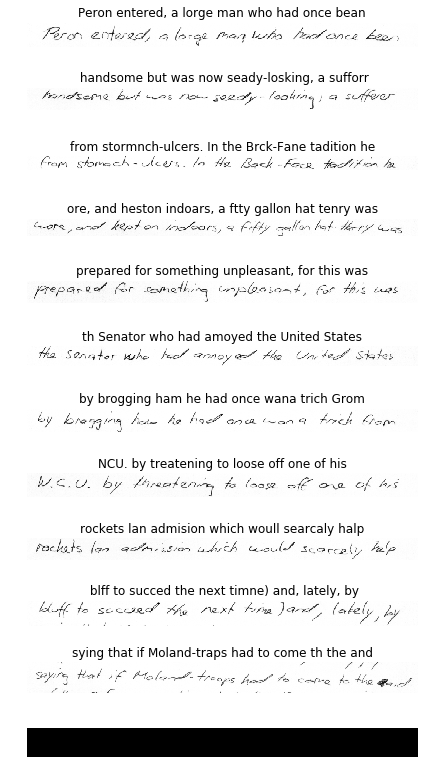

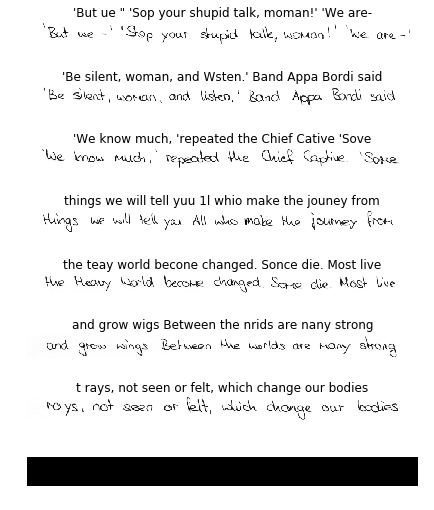

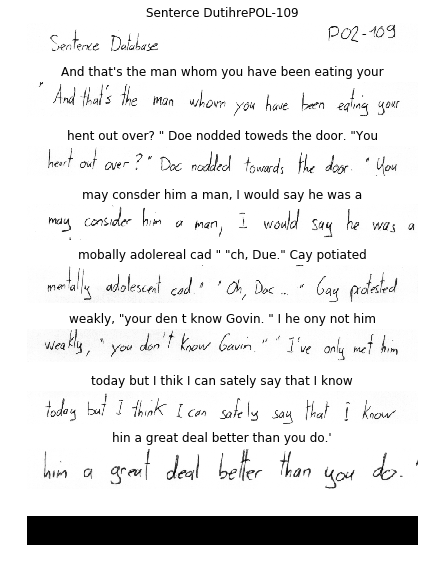

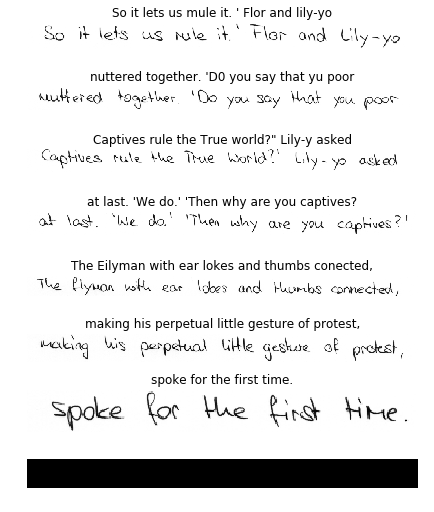

In [24]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_arg_max(line_character_probs)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

#### Lexicon search

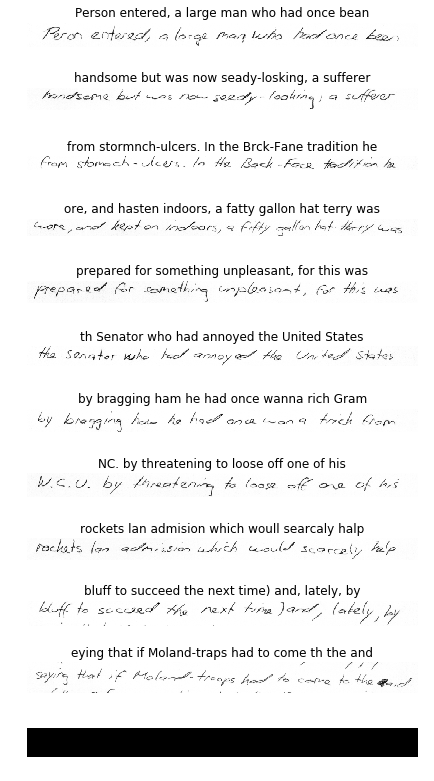

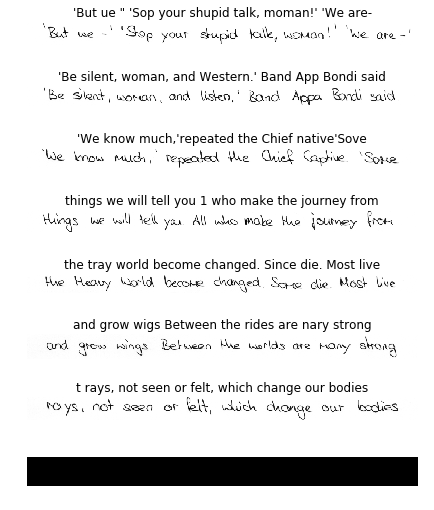

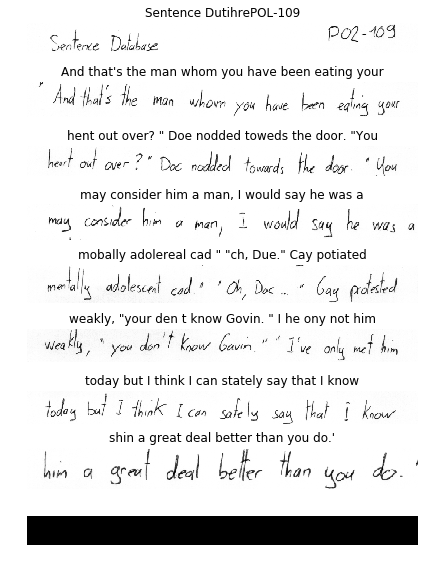

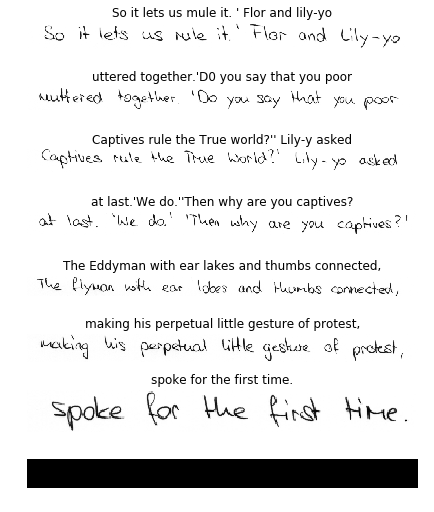

In [25]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        line_image = line_images_array[i][j]
        decoded_line = get_lexicon_search(line_character_probs)
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

#### Lexicon and beam searching

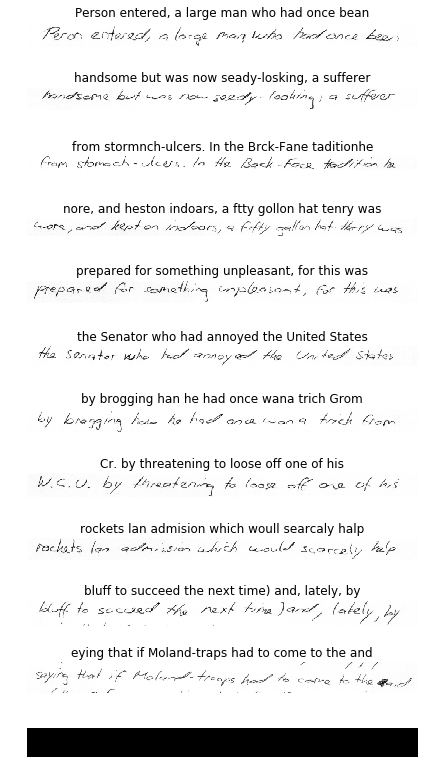

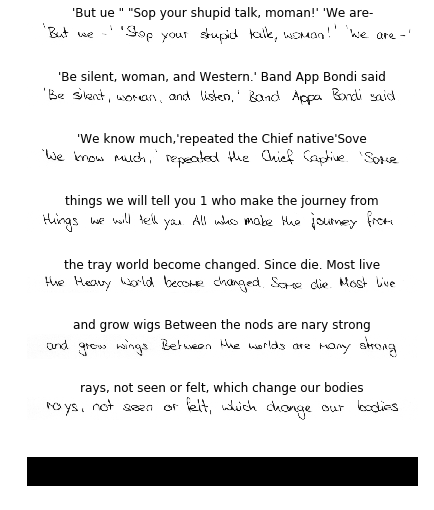

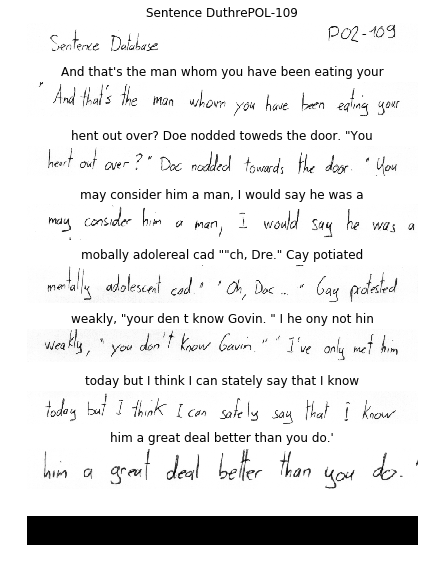

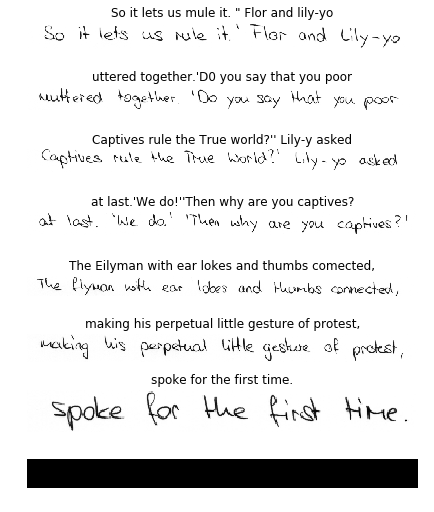

In [26]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_text_from_chracter_probs_with_language_model(line_character_probs) 
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# Quantitative Results
Iterative through the test data with the previous tests to obtain the total Character Error Rate (CER).

In [27]:
sclite = Sclite_helper()

def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in range(len(test_ds)):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=(1120, 800))
        paragraph_bb = paragraph_segmentation_net(resized_image)
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb[0].asnumpy(), image_size=(700, 700))
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk)
        line_bbs = sort_bbs_line_by_line(word_bb)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = handwriting_recognition_transform(line_image)
            character_probabilities = handwriting_line_recognition_net(line_image)
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot", '\"').replace("&amp", "&").replace('";', '\"')[:-1]
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    _, er = sclite.get_cer()
    print("Mean CER = {}".format(er))

In [28]:
get_qualitative_results(get_arg_max)

Mean CER = 13.599999999999994


In [29]:
get_qualitative_results(get_lexicon_search)

Mean CER = 12.299999999999997


In [30]:
get_qualitative_results(get_text_from_chracter_probs_with_language_model)

Mean CER = 12.599999999999994
